# Total cases and deaths for several country based on available data

In [205]:
from bs4 import BeautifulSoup
from requests import get
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import os

%matplotlib inline

### ECDC data

In [206]:
# Another sources but no information on data source
ecdc_url = "https://www.ecdc.europa.eu/en/publications-data/download-todays-data-geographic-distribution-covid-19-cases-worldwide"
response = get(ecdc_url)

# Since the link changes daily, let's make some soup
soup = BeautifulSoup(response.text, 'html.parser')
ecdc_data_url = soup.find('a', attrs={'href': re.compile("^https://www.ecdc.europa.eu/sites/default/files/documents/COVID-19-geographic-disbtribution-worldwide-")}).get('href')

ecdc_data = pd.read_excel(ecdc_data_url)
ecdc_data['source'] = 'ecdc'

# Renaming columns
ecdc_data.rename(columns={'dateRep':'date', 'countriesAndTerritories':'country', 'cases':'new_cases', 'deaths':'new_deaths'}, inplace=True)

# Name correction...
ecdc_data.loc[ecdc_data.country=='United States of America', 'country'] = 'U.S.A'

# Date conversion
ecdc_data['date'] = pd.to_datetime(ecdc_data['date'])
ecdc_data.sort_values(by='date', inplace=True)

# Totals had to be calculated
ecdc_data['total_cases'] = ecdc_data.groupby('country')['new_cases'].cumsum()
ecdc_data['total_deaths'] = ecdc_data.groupby('country')['new_deaths'].cumsum()

# Fatality rates
ecdc_data['case_fatality_rate'] = 100*(ecdc_data.total_deaths/ecdc_data.total_cases)

# Keeping only those of interests
ecdc_data = ecdc_data.filter(['date', 'country', 'total_cases', 'total_deaths', 'source', 'case_fatality_rate'])




### Epidemy start offset

Since each country have had different start dates regarding this epidemy, we  offset the dates by the date with a certain number of cases/deaths identified in ECDC data (since they have the most history) for each country.

In [207]:
number_of_cases_for_offset = 100
number_of_deaths_for_offset = 50

# Country with at least one cases
country_gt_one_case = ecdc_data[(ecdc_data.total_cases>number_of_cases_for_offset) & (ecdc_data.total_cases>number_of_deaths_for_offset)].groupby('country').head(1).country.unique()
ecdc_data = ecdc_data[ecdc_data.country.isin(country_gt_one_case)]

# Looking for offsets
china_start_date = pd.Timestamp('2019-12-31') # For future use
country_offset_date_cases = dict(ecdc_data[(ecdc_data.total_cases>number_of_cases_for_offset)].groupby('country').head(1)[['country', 'date']].values)
country_offset_date_deaths = dict(ecdc_data[(ecdc_data.total_cases>number_of_deaths_for_offset)].groupby('country').head(1)[['country', 'date']].values)

### Merging the data

We merge WHO and ECDC data and add a column with the days since first case for each country.

We only keep the countries appearing in both.

In [208]:
data = pd.melt(ecdc_data, 
                         id_vars=['date', 'country', 'source'], 
                         value_vars=['total_cases', 'total_deaths', 'case_fatality_rate'])

data['offset_cases'] = data.apply(lambda x: (x['date'] - country_offset_date_cases[x['country']]).days, axis=1)  
data['offset_deaths'] = data.apply(lambda x: (x['date'] - country_offset_date_deaths[x['country']]).days, axis=1)  


## Plots

In [209]:
countries_to_plot = ['France', 'Spain', 'Italy', 'China', 'United_States_of_America', 'South_Korea']
data_plot = data[data.country.isin(countries_to_plot)]

In [210]:
def plot(data, var_to_plot, ylog=True, filename=None):
    countries = data.country.unique()
    rgb_values = sns.color_palette("Set2", len(countries))
    color_map = dict(zip(countries, rgb_values))

    fig = plt.figure(figsize=(15, 8))
    ax = fig.add_subplot()
    
    for country in countries:
        data_plot = data[(data.country==country) & (data.variable==var_to_plot)]
        ax.plot(data_plot.offset_cases,
                data_plot.value,
                color=color_map[country],
               label=f'{country} ({country_offset_date_cases[country].strftime("%d/%m/%Y")})')
    if ylog:
        plt.yscale('log')
    
    xmin = min(data[(data.variable=='total_cases') & (data.value>number_of_cases_for_offset*0.6)]['offset_cases'])
    xmax = (pd.to_datetime('today')-china_start_date).days
    ymin = 1 + np.nanmin(data[(data.variable==var_to_plot) & (data.offset_cases>=xmin)].value)
    ymax = 1.25*np.nanmax(data[data.variable==var_to_plot].value)
    plt.xlim(xmin, xmax)
    plt.ylim(ymin, ymax)
    plt.xlabel(f'Number of days since the {number_of_cases_for_offset}th case')
    plt.ylabel(f'Number of {var_to_plot}')
    
    plt.legend()
    if filename != None:
        plt.savefig(filename)
    plt.show()

### Total cases and deaths since the first case for each country

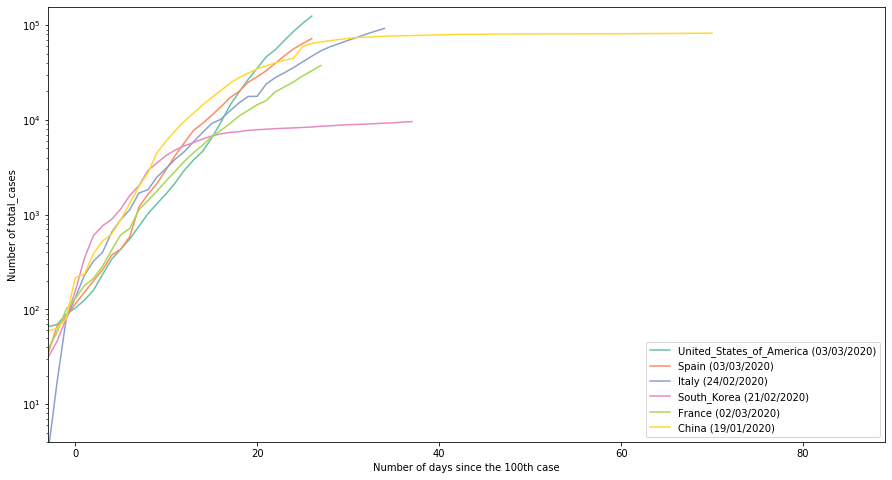

In [211]:
plot(data_plot, 'total_cases', filename='./Total_cases.png')

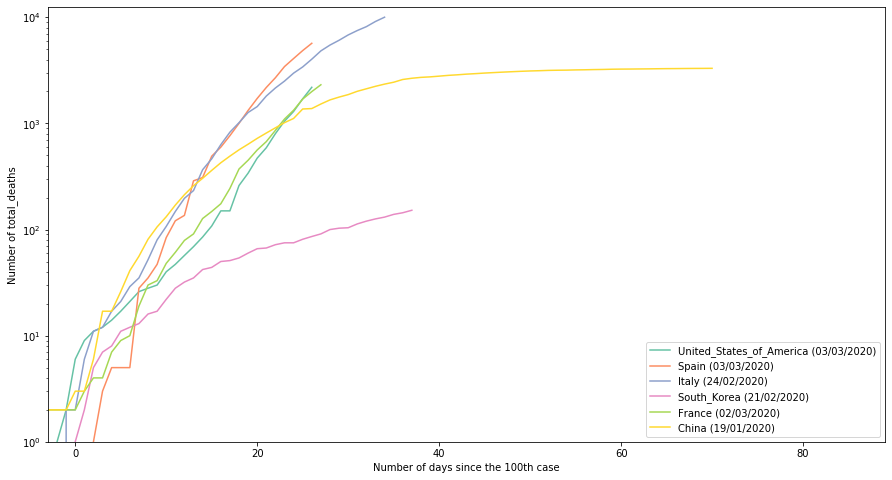

In [212]:
plot(data_plot, 'total_deaths', filename='./Total_deaths.png')

### Morbidity

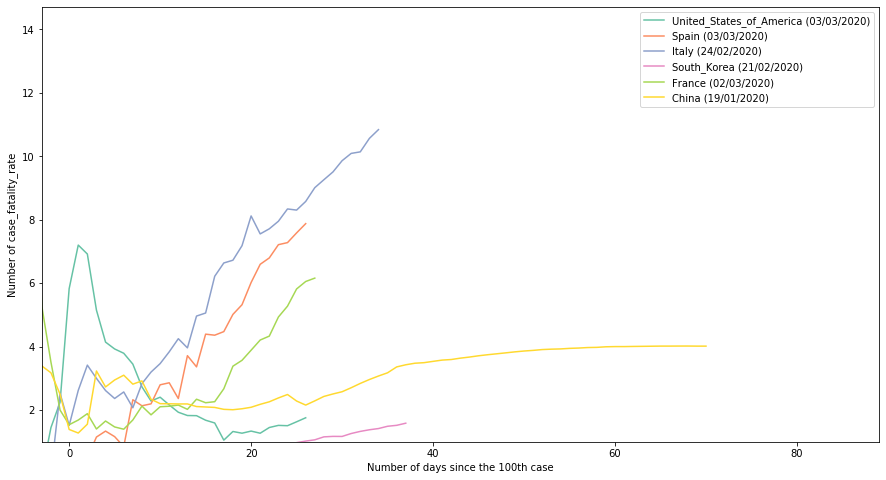

In [213]:
plot(data_plot, 'case_fatality_rate', False, './Total_deaths.png')

### Linear y-axis

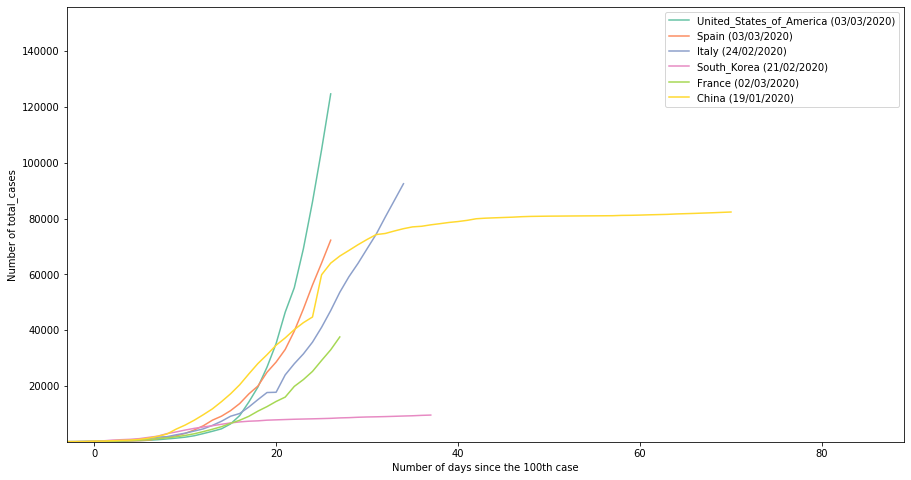

In [214]:
plot(data_plot, 'total_cases', False, './Total_cases_lin.png')

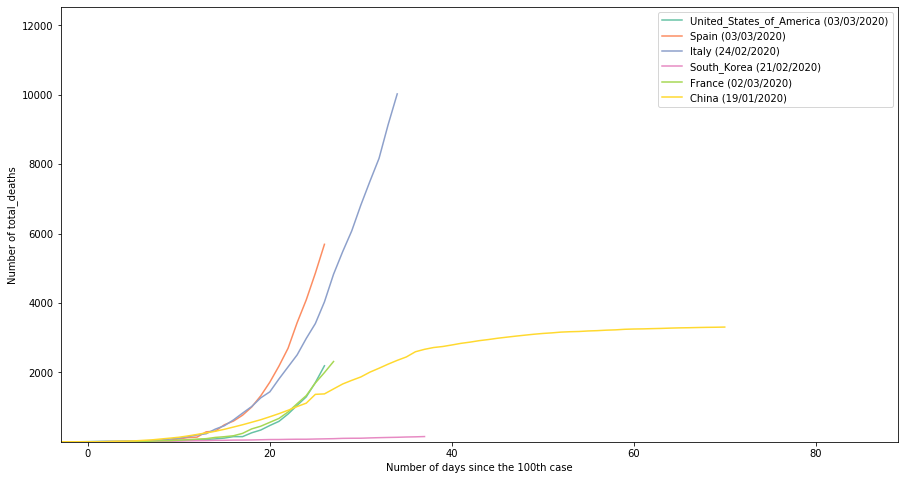

In [216]:
plot(data_plot, 'total_deaths', False, './Total_deaths_lin.png')